# Titration Experiment

In [1]:
#############################
#   Experiment parameters   #
#############################
ROOT_DIR = '/analysis/gh-msun/'
PROJECT_SLUG = '2023_06_26_SRT_deconvolution_MS'
EXPERIMENT = 'primary_immune'
TITRATING_CELLTYPE = 'Blueprint-B'
TITRATING_CELLTYPE_ATLAS = 'immune_b' # cell type name in atlas different
BACKGROUND = 'wholeblood' # background: uniform / wholeblood 
N_REPLICATES = 2 # number of replicates for each mixture
SEED = 888 # need to change for different experiment
TOTAL_READS_TO_SAMPLE = 1000000

# make sure the orders of the two list match
CELLTYPES = ['Blueprint-CD4', 'Blueprint-CD8', 'Blueprint-B', 'Blueprint-NK', 'Blueprint-Mono', 'Blueprint-Neutro']
ABRIDGED_NAMES = ['CD4', 'CD8', 'B', 'NK', 'MONO', 'NEUTRO'] # for directory name

# TITRATION_LIST = [0.2, 0.15, 0.10, 0.08, 0.06, 0.04, 0.02, 0.01, 
#                   0.008, 0.006, 0.004, 0.002, 0.001, 0]
TITRATION_LIST=[0.2, 0.15]

# proportion of cells in real whole blood (sum to 1)
WHOLE_BLOOD_ABUNDANCE = {'Blueprint-B':0.06,
                         'Blueprint-Mono':0.09,
                         'Blueprint-Neutro':0.57,
                         'Blueprint-CD4':0.16,
                         'Blueprint-CD8':0.07,
                         'Blueprint-NK':0.05}
    

In [2]:
# Parameters
ROOT_DIR = "/analysis/gh-msun/"
PROJECT_SLUG = "2023_06_26_SRT_deconvolution_MS"
EXPERIMENT = "primary_immune"
TITRATING_CELLTYPE = "Blueprint-Neutro"
TITRATING_CELLTYPE_ATLAS = "immune_neutro"
BACKGROUND = "wholeblood"
N_REPLICATES = 20
SEED = 520710
TOTAL_READS_TO_SAMPLE = 1000000
CELLTYPES = ["Blueprint-CD4", "Blueprint-CD8", "Blueprint-B", "Blueprint-NK", "Blueprint-Mono", "Blueprint-Neutro"]
ABRIDGED_NAMES = ["CD4", "CD8", "B", "NK", "MONO", "NEUTRO"]
TITRATION_LIST = [0.2, 0.15, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.008, 0.006, 0.004, 0.002, 0.001, 0]
WHOLE_BLOOD_ABUNDANCE = {"Blueprint-B": 0.06, "Blueprint-Mono": 0.09, "Blueprint-Neutro": 0.57, "Blueprint-CD4": 0.16, "Blueprint-CD8": 0.07, "Blueprint-NK": 0.05}


In [3]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import functools
import os
import regex as re
import random
import importlib
import sys

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import IntegerType, LongType, ArrayType, StringType, DoubleType
from pyspark.sql.functions import udf, explode, broadcast, count, lit, length, col
from pyspark.sql import DataFrame
from pyspark.sql.types import StructType

# UPDATE HOME!
os.environ["SPARK_HOME"] = "/home/ec2-user/mambaforge/envs/2023_06_26_SRT_deconvolution_MS/lib/python3.7/site-packages/pyspark"
# THIS needs to be set-up before running the notebook
os.environ["SPARK_LOCAL_DIRS"] = "/temp"
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

spark_conf = SparkConf()
spark_conf.set("spark.ui.showConsoleProgress", "True")
spark_conf.set("spark.executor.instances", "2")
spark_conf.set("spark.executor.cores", "2")
spark_conf.set("spark.executor.memory", "16g")
spark_conf.set("spark.driver.memory", "64g")
spark_conf.set("spark.driver.maxResultSize", "32g")
spark_conf.set("spark.parquet.filterPushdown", "true")
spark_conf.set("spark.local.dir", "/temp")
spark_conf.getAll()

sc = SparkContext(conf=spark_conf)
sc.setLogLevel("ERROR")
spark = SparkSession(sc)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
sns.set_context('talk')

/home/ec2-user/mambaforge/envs/2023_06_26_SRT_deconvolution_MS/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


In [4]:
#---Local paths---#
PROJECT_DIR = ROOT_DIR + f'projects/{PROJECT_SLUG}/'

#---Load all custom scripts---#
SCRIPT_DIR = PROJECT_DIR + 'scripts/'
sys.path.append(SCRIPT_DIR)

import create_mixture as cm
import score_matrix as sm
import deconvolution as dcnv
import helper as hlpr

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [5]:
importlib.reload(cm)
importlib.reload(sm)
importlib.reload(dcnv)
importlib.reload(hlpr)

<module 'helper' from '/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/scripts/helper.py'>

In [6]:
#################################
#   Set titration proportions   #
#################################

# Reorder such that the titrating cell type comes first
CELLTYPES_unordered = CELLTYPES.copy()
CELLTYPES = hlpr.titration_reordering(list_of_cell_types=CELLTYPES, 
                                      titrating_cell_type=TITRATING_CELLTYPE)

# Reorder abridged name
ABRIDGED_NAMES = hlpr.reorder_abridged_name(unordered_celltypes=CELLTYPES_unordered,
                                            ordered_celltypes=CELLTYPES,
                                            unordered_abridged_names=ABRIDGED_NAMES)
    
# set titration proportions
if BACKGROUND == 'uniform':
    PROPORTIONS = hlpr.generate_uniform_background_proportions(titration_list=TITRATION_LIST, 
                                                               cell_types=CELLTYPES)

if BACKGROUND == 'wholeblood':
    PROPORTIONS = hlpr.generate_custom_background_proportions(titration_list=TITRATION_LIST, 
                                                              custom_proportion=WHOLE_BLOOD_ABUNDANCE, 
                                                              list_of_celltypes=CELLTYPES, 
                                                              titrating_celltype=TITRATING_CELLTYPE)

PROPORTIONS[0]    

[0.2,
 0.29767441860465116,
 0.1302325581395349,
 0.11162790697674418,
 0.0930232558139535,
 0.16744186046511628]

## Create mixture

In [7]:
############################
#   Parameters and paths   # 
############################
EXPERIMENT_DIR = PROJECT_DIR + f'output/experiment/{EXPERIMENT}/'
EXPERIMENT_NAME = f'{TITRATING_CELLTYPE}-{BACKGROUND}/'
PARQUET_PATH = PROJECT_DIR + 'output/mixture_source/'
EXPERIMENT_CELLTYPE_DIR = EXPERIMENT_DIR + f'{EXPERIMENT_NAME}/'
RESULT_PATH = EXPERIMENT_CELLTYPE_DIR + 'mixture/'


In [8]:
%%time
# load parquet files for each celltype & count rows
parquet_df, total_reads_per_celltype = cm.load_parquet_dataframe(parquet_path=PARQUET_PATH,
                                                                  cell_types=CELLTYPES,
                                                                  spark=spark,
                                                                  verbose=True)

# mix cell types for each proportion set
cm.mix_celltypes_multiple_proportions(parquet_df=parquet_df,
                                       total_reads_per_celltype=total_reads_per_celltype,
                                    #    n=len(TITRATION_LIST), 
                                       n=N_REPLICATES,
                                       cell_types=CELLTYPES, 
                                       cell_type_abridged_name=ABRIDGED_NAMES, 
                                       total_reads_to_sample=TOTAL_READS_TO_SAMPLE, 
                                       list_of_proportions=PROPORTIONS, 
                                       seed=SEED, 
                                       result_path=RESULT_PATH, 
                                       spark=spark,
                                       verbose=False, 
                                       save=True)

>>> Load parquet files and count rows... <<<
----------> Loading cell type: Blueprint-Neutro


----------> Loading cell type: Blueprint-CD4


----------> Loading cell type: Blueprint-CD8


----------> Loading cell type: Blueprint-B


----------> Loading cell type: Blueprint-NK


----------> Loading cell type: Blueprint-Mono


>>> Complete. <<< 

>>> Start mixing... <<<
--> PROPORTION: [0.2, 0.29767441860465116, 0.1302325581395349, 0.11162790697674418, 0.0930232558139535, 0.16744186046511628]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.15, 0.31627906976744186, 0.13837209302325582, 0.11860465116279069, 0.09883720930232559, 0.17790697674418604]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.1, 0.33488372093023255, 0.14651162790697675, 0.12558139534883722, 0.1046511627906977, 0.1883720930232558]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.08, 0.34232558139534885, 0.14976744186046514, 0.1283720930232558, 0.10697674418604652, 0.1925581395348837]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.06, 0.3497674418604651, 0.15302325581395348, 0.13116279069767442, 0.10930232558139535, 0.1967441860465116]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.04, 0.3572093023255814, 0.15627906976744185, 0.133953488372093, 0.1116279069767442, 0.20093023255813952]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.02, 0.36465116279069765, 0.15953488372093025, 0.13674418604651162, 0.11395348837209303, 0.20511627906976743]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.01, 0.3683720930232558, 0.16116279069767442, 0.13813953488372094, 0.11511627906976746, 0.20720930232558138]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.008, 0.36911627906976746, 0.16148837209302327, 0.1384186046511628, 0.11534883720930234, 0.20762790697674416]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.006, 0.36986046511627907, 0.1618139534883721, 0.13869767441860464, 0.11558139534883723, 0.20804651162790697]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.004, 0.3706046511627907, 0.16213953488372093, 0.1389767441860465, 0.1158139534883721, 0.20846511627906975]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.002, 0.37134883720930234, 0.1624651162790698, 0.13925581395348838, 0.116046511627907, 0.20888372093023255]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.001, 0.37172093023255814, 0.1626279069767442, 0.1393953488372093, 0.11616279069767443, 0.20909302325581394]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0, 0.37209302325581395, 0.16279069767441862, 0.13953488372093023, 0.11627906976744187, 0.20930232558139533]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


>>> Complete. <<< 

CPU times: user 1.35 s, sys: 396 ms, total: 1.75 s
Wall time: 23min 41s


## Compute score matrix

In [9]:
############################
#   Parameters and paths   # 
############################

FILTER_CG_COUNT = 3
FILTER_CG_COUNT_REGION = 1

REGIONS = 'deconvolution_v2.v23_conv.with_cpg_index'
REGION_BED_COLS = [
    'region_chr', 'region_start', 'region_end', 
    'region_cpg_index_min', 'region_cpg_index_max', 'region_id'
]

# Regions
REGION_PATH = (
    PROJECT_DIR + '/stage/panel_data/{regions}.bed'
).format(regions=REGIONS)

# CpG map; genomic coordinate to CpG index;
CPG_MAP_PATH = PROJECT_DIR + '/stage/cpg_loci/cpg_loci_hg19.combined_annot.tsv.gz'

#--- Where to store results
PATH_TO_MIXTURE_DIR = EXPERIMENT_CELLTYPE_DIR + 'mixture/'
RESULT_PATH = EXPERIMENT_CELLTYPE_DIR


In [10]:
cpg_map = pd.read_csv(CPG_MAP_PATH, usecols=['chr', 'start', 'end', 'cpg_index', 'cpg_index_hg38'], sep='\t')

In [11]:
%%time
ridxs = ~cpg_map['cpg_index_hg38'].isna()
hg19_hg38_map = dict(itertools.zip_longest(cpg_map[ridxs]['cpg_index'], cpg_map[ridxs]['cpg_index_hg38'].astype(int)))
hg38_hg19_map = dict(itertools.zip_longest(cpg_map[ridxs]['cpg_index_hg38'].astype(int), cpg_map[ridxs]['cpg_index']))

CPU times: user 14.8 s, sys: 5.12 s, total: 19.9 s
Wall time: 19.8 s


In [12]:
region_df = pd.read_csv(REGION_PATH, sep='\t', usecols=range(0, 6), names=REGION_BED_COLS)

region_df['region_cpg_index_max'] -= 1
region_df.sort_values('region_cpg_index_min', inplace=True)
region_df['region_cpg_index_min_hg38'] = region_df['region_cpg_index_min'].map(hg19_hg38_map)
region_df['region_cpg_index_max_hg38'] = region_df['region_cpg_index_max'].map(hg19_hg38_map)

region_df.shape[0], region_df['region_id'].nunique()

(1658, 1658)

In [13]:
ridxs = ~region_df['region_cpg_index_min_hg38'].isna()
ridxs &= ~region_df['region_cpg_index_max_hg38'].isna()
region_df = region_df[ridxs].copy()
region_df.shape[0], region_df['region_id'].nunique()

(1658, 1658)

In [14]:
cg_count_hg19 = region_df['region_cpg_index_max']-region_df['region_cpg_index_min'] + 1
cg_count_hg38 = region_df['region_cpg_index_max_hg38']-region_df['region_cpg_index_min_hg38'] + 1
ridxs = (cg_count_hg19==cg_count_hg38)
ridxs &= (cg_count_hg19>=FILTER_CG_COUNT_REGION)
region_df = region_df[ridxs].copy()
region_df.shape[0], region_df['region_id'].nunique()

(1657, 1657)

In [15]:
region_df['region_cpg_index_min_hg38'] = region_df['region_cpg_index_min_hg38'].astype(int)
region_df['region_cpg_index_max_hg38'] = region_df['region_cpg_index_max_hg38'].astype(int)

In [16]:
### Restrict to immune regions
#-------------- CHANGE HERE FOR DIFFERENT REGION SUBSET ----------------------
# BLUEPRINT immune regions
ATLAS_PATH = PROJECT_DIR + f'/output/reference/deconv_inhouse_v2.atlas.tsv.gz'
atlas = pd.read_csv(ATLAS_PATH, sep='\t')
subset_region_set = set(atlas.region_id)
#-----------------------------------------------------------------------------

# filter regions down to regions of interest
region_df = region_df[region_df['region_id'].isin(subset_region_set)]
region_df.head()

,region_chr,region_start,region_end,region_cpg_index_min,region_cpg_index_max,region_id,region_cpg_index_min_hg38,region_cpg_index_max_hg38
0,chr1,1114771,1114971,20117,20129,Immune_Broad_B-chr1:1114772-1114971,21119,21131
1,chr1,1157450,1157720,21684,21703,Immune_Broad_NK-chr1:1157451-1157720,22686,22705
2,chr1,1157879,1158277,21710,21726,Immune_Broad_NK-chr1:1157880-1158277,22712,22728
14,chr1,6341182,6341377,140667,140681,Immune_Broad_Eosi-chr1:6341183-6341377,142368,142382
19,chr1,9147788,9147871,188605,188608,Immune_Broad_Neutro-chr1:9147789-9147871,190307,190310


In [17]:
%%time

PAT_COLS = [
    'molecule_id', 'chr', 'number_molecules',
    'cpg_index_min', 'cpg_index_max', 'pat_string', 'region_id', 'region_cpg_index_min', 'region_cpg_index_max'
]

QUANTILES = [0.1, 0.25, 0.75, 0.9]
KMERS = [1, 3, 4]
RATES_LEQ = [0.25]
RATES_GEQ = [0.75]

RETURN_SCHEMA = StructType()\
    .add('region_id', 'string')\
    .add('number_molecules', 'integer')\
    .add('meth_k1', 'integer')\
    .add('unmeth_k1', 'integer')\
    .add('total_k1', 'integer')\
    .add('meth_k3', 'integer')\
    .add('unmeth_k3', 'integer')\
    .add('total_k3', 'integer')\
    .add('meth_k4', 'integer')\
    .add('unmeth_k4', 'integer')\
    .add('total_k4', 'integer')\
    .add('frac_alpha_leq_25pct', 'float')\
    .add('frac_alpha_geq_75pct', 'float')

compute_frag_scores_udf = sm.compute_frag_scores(cpg_number_cutoff=FILTER_CG_COUNT, schema=RETURN_SCHEMA, kmers=KMERS, rates_leq=RATES_LEQ, rates_geq=RATES_GEQ)


# compute methyl score for are parquet files
sm.score_matrix_from_mixture_directory(path_to_mixture_dir = PATH_TO_MIXTURE_DIR, 
                                       result_path = RESULT_PATH, 
                                       pat_cols = PAT_COLS, 
                                       region_df = region_df, 
                                       batch_size = 20, 
                                       schema = RETURN_SCHEMA, 
                                       spark=spark,
                                       compute_frag_scores_udf=compute_frag_scores_udf,
                                       save=True, 
                                       verbose=False)

>>> Start computing score matrices <<< 

--> E2NEUTRO_E2977CD4_E1302CD8_E1116B_E093NK_E1674MONO
--------> Computing score matrix for mix0_seed106375


--------> Computing score matrix for mix1_seed803133


--------> Computing score matrix for mix2_seed754789


--------> Computing score matrix for mix3_seed669141


--------> Computing score matrix for mix4_seed362477


--------> Computing score matrix for mix5_seed956194


--------> Computing score matrix for mix6_seed669884


--------> Computing score matrix for mix7_seed756130


--------> Computing score matrix for mix8_seed89737


--------> Computing score matrix for mix9_seed704877


--------> Computing score matrix for mix10_seed628175


--------> Computing score matrix for mix11_seed821572


--------> Computing score matrix for mix12_seed276913


--------> Computing score matrix for mix13_seed963369


--------> Computing score matrix for mix14_seed64384


--------> Computing score matrix for mix15_seed111665


--------> Computing score matrix for mix16_seed528725


--------> Computing score matrix for mix17_seed715905


--------> Computing score matrix for mix18_seed624900


--------> Computing score matrix for mix19_seed696504




--> E15NEUTRO_E3163CD4_E1384CD8_E1186B_E0988NK_E1779MONO
--------> Computing score matrix for mix0_seed10715


--------> Computing score matrix for mix1_seed989127


--------> Computing score matrix for mix2_seed976185


--------> Computing score matrix for mix3_seed530891


--------> Computing score matrix for mix4_seed467536


--------> Computing score matrix for mix5_seed937830


--------> Computing score matrix for mix6_seed127339


--------> Computing score matrix for mix7_seed283668


--------> Computing score matrix for mix8_seed223469


--------> Computing score matrix for mix9_seed349266


--------> Computing score matrix for mix10_seed78892


--------> Computing score matrix for mix11_seed352855


--------> Computing score matrix for mix12_seed973178


--------> Computing score matrix for mix13_seed351195


--------> Computing score matrix for mix14_seed94361


--------> Computing score matrix for mix15_seed993641


--------> Computing score matrix for mix16_seed958661


--------> Computing score matrix for mix17_seed925941


--------> Computing score matrix for mix18_seed209046


--------> Computing score matrix for mix19_seed287932




--> E1NEUTRO_E3349CD4_E1465CD8_E1256B_E1047NK_E1884MONO
--------> Computing score matrix for mix0_seed831448


--------> Computing score matrix for mix1_seed562190


--------> Computing score matrix for mix2_seed691467


--------> Computing score matrix for mix3_seed201543


--------> Computing score matrix for mix4_seed404621


--------> Computing score matrix for mix5_seed715136


--------> Computing score matrix for mix6_seed612261


--------> Computing score matrix for mix7_seed705833


--------> Computing score matrix for mix8_seed206278


--------> Computing score matrix for mix9_seed289568


--------> Computing score matrix for mix10_seed28997


--------> Computing score matrix for mix11_seed920352


--------> Computing score matrix for mix12_seed524691


--------> Computing score matrix for mix13_seed241664


--------> Computing score matrix for mix14_seed291776


--------> Computing score matrix for mix15_seed254167


--------> Computing score matrix for mix16_seed702742


--------> Computing score matrix for mix17_seed733092


--------> Computing score matrix for mix18_seed9761


--------> Computing score matrix for mix19_seed625795




--> E08NEUTRO_E3423CD4_E1498CD8_E1284B_E107NK_E1926MONO
--------> Computing score matrix for mix0_seed573320


--------> Computing score matrix for mix1_seed106323


--------> Computing score matrix for mix2_seed254137


--------> Computing score matrix for mix3_seed817970


--------> Computing score matrix for mix4_seed881443


--------> Computing score matrix for mix5_seed541428


--------> Computing score matrix for mix6_seed941368


--------> Computing score matrix for mix7_seed826437


--------> Computing score matrix for mix8_seed480736


--------> Computing score matrix for mix9_seed802427


--------> Computing score matrix for mix10_seed978196


--------> Computing score matrix for mix11_seed499021


--------> Computing score matrix for mix12_seed665740


--------> Computing score matrix for mix13_seed595611


--------> Computing score matrix for mix14_seed816522


--------> Computing score matrix for mix15_seed134638


--------> Computing score matrix for mix16_seed731720


--------> Computing score matrix for mix17_seed636351


--------> Computing score matrix for mix18_seed54424


--------> Computing score matrix for mix19_seed563414




--> E06NEUTRO_E3498CD4_E153CD8_E1312B_E1093NK_E1967MONO
--------> Computing score matrix for mix0_seed587905


--------> Computing score matrix for mix1_seed195945


--------> Computing score matrix for mix2_seed967837


--------> Computing score matrix for mix3_seed455992


--------> Computing score matrix for mix4_seed290186


--------> Computing score matrix for mix5_seed437619


--------> Computing score matrix for mix6_seed50705


--------> Computing score matrix for mix7_seed719669


--------> Computing score matrix for mix8_seed508939


--------> Computing score matrix for mix9_seed286826


--------> Computing score matrix for mix10_seed181571


--------> Computing score matrix for mix11_seed587909


--------> Computing score matrix for mix12_seed429164


--------> Computing score matrix for mix13_seed850536


--------> Computing score matrix for mix14_seed617496


--------> Computing score matrix for mix15_seed673223


--------> Computing score matrix for mix16_seed893897


--------> Computing score matrix for mix17_seed390863


--------> Computing score matrix for mix18_seed851203


--------> Computing score matrix for mix19_seed536607




--> E04NEUTRO_E3572CD4_E1563CD8_E134B_E1116NK_E2009MONO
--------> Computing score matrix for mix0_seed627223


--------> Computing score matrix for mix1_seed662222


--------> Computing score matrix for mix2_seed790631


--------> Computing score matrix for mix3_seed70184


--------> Computing score matrix for mix4_seed668794


--------> Computing score matrix for mix5_seed596259


--------> Computing score matrix for mix6_seed748511


--------> Computing score matrix for mix7_seed194235


--------> Computing score matrix for mix8_seed281476


--------> Computing score matrix for mix9_seed382353


--------> Computing score matrix for mix10_seed986048


--------> Computing score matrix for mix11_seed10285


--------> Computing score matrix for mix12_seed918181


--------> Computing score matrix for mix13_seed639922


--------> Computing score matrix for mix14_seed887890


--------> Computing score matrix for mix15_seed109766


--------> Computing score matrix for mix16_seed182756


--------> Computing score matrix for mix17_seed137914


--------> Computing score matrix for mix18_seed211377


--------> Computing score matrix for mix19_seed533198




--> E02NEUTRO_E3647CD4_E1595CD8_E1367B_E114NK_E2051MONO
--------> Computing score matrix for mix0_seed184439


--------> Computing score matrix for mix1_seed890055


--------> Computing score matrix for mix2_seed914035


--------> Computing score matrix for mix3_seed749219


--------> Computing score matrix for mix4_seed806557


--------> Computing score matrix for mix5_seed59500


--------> Computing score matrix for mix6_seed74832


--------> Computing score matrix for mix7_seed893971


--------> Computing score matrix for mix8_seed692059


--------> Computing score matrix for mix9_seed359581


--------> Computing score matrix for mix10_seed612356


--------> Computing score matrix for mix11_seed58496


--------> Computing score matrix for mix12_seed40944


--------> Computing score matrix for mix13_seed687511


--------> Computing score matrix for mix14_seed251586


--------> Computing score matrix for mix15_seed657279


--------> Computing score matrix for mix16_seed824491


--------> Computing score matrix for mix17_seed813987


--------> Computing score matrix for mix18_seed217102


--------> Computing score matrix for mix19_seed712971




--> E01NEUTRO_E3684CD4_E1612CD8_E1381B_E1151NK_E2072MONO
--------> Computing score matrix for mix0_seed335287


--------> Computing score matrix for mix1_seed441571


--------> Computing score matrix for mix2_seed17595


--------> Computing score matrix for mix3_seed474533


--------> Computing score matrix for mix4_seed185633


--------> Computing score matrix for mix5_seed387031


--------> Computing score matrix for mix6_seed631186


--------> Computing score matrix for mix7_seed778032


--------> Computing score matrix for mix8_seed268889


--------> Computing score matrix for mix9_seed508068


--------> Computing score matrix for mix10_seed117067


--------> Computing score matrix for mix11_seed509633


--------> Computing score matrix for mix12_seed749091


--------> Computing score matrix for mix13_seed779007


--------> Computing score matrix for mix14_seed672425


--------> Computing score matrix for mix15_seed812913


--------> Computing score matrix for mix16_seed588185


--------> Computing score matrix for mix17_seed141231


--------> Computing score matrix for mix18_seed984111


--------> Computing score matrix for mix19_seed364776




--> E008NEUTRO_E3691CD4_E1615CD8_E1384B_E1153NK_E2076MONO
--------> Computing score matrix for mix0_seed74036


--------> Computing score matrix for mix1_seed77568


--------> Computing score matrix for mix2_seed906701


--------> Computing score matrix for mix3_seed511159


--------> Computing score matrix for mix4_seed571244


--------> Computing score matrix for mix5_seed361678


--------> Computing score matrix for mix6_seed35866


--------> Computing score matrix for mix7_seed561576


--------> Computing score matrix for mix8_seed186910


--------> Computing score matrix for mix9_seed950409


--------> Computing score matrix for mix10_seed146061


--------> Computing score matrix for mix11_seed80832


--------> Computing score matrix for mix12_seed843046


--------> Computing score matrix for mix13_seed561420


--------> Computing score matrix for mix14_seed880289


--------> Computing score matrix for mix15_seed907918


--------> Computing score matrix for mix16_seed739970


--------> Computing score matrix for mix17_seed629975


--------> Computing score matrix for mix18_seed451669


--------> Computing score matrix for mix19_seed88694




--> E006NEUTRO_E3699CD4_E1618CD8_E1387B_E1156NK_E208MONO
--------> Computing score matrix for mix0_seed262930


--------> Computing score matrix for mix1_seed326000


--------> Computing score matrix for mix2_seed295309


--------> Computing score matrix for mix3_seed888906


--------> Computing score matrix for mix4_seed640912


--------> Computing score matrix for mix5_seed453690


--------> Computing score matrix for mix6_seed54630


--------> Computing score matrix for mix7_seed428844


--------> Computing score matrix for mix8_seed653901


--------> Computing score matrix for mix9_seed989540


--------> Computing score matrix for mix10_seed217241


--------> Computing score matrix for mix11_seed722015


--------> Computing score matrix for mix12_seed320132


--------> Computing score matrix for mix13_seed890195


--------> Computing score matrix for mix14_seed958653


--------> Computing score matrix for mix15_seed465001


--------> Computing score matrix for mix16_seed512536


--------> Computing score matrix for mix17_seed412837


--------> Computing score matrix for mix18_seed686857


--------> Computing score matrix for mix19_seed485859




--> E004NEUTRO_E3706CD4_E1621CD8_E139B_E1158NK_E2085MONO
--------> Computing score matrix for mix0_seed256869


--------> Computing score matrix for mix1_seed513277


--------> Computing score matrix for mix2_seed220792


--------> Computing score matrix for mix3_seed1964


--------> Computing score matrix for mix4_seed864210


--------> Computing score matrix for mix5_seed273365


--------> Computing score matrix for mix6_seed880225


--------> Computing score matrix for mix7_seed473665


--------> Computing score matrix for mix8_seed586949


--------> Computing score matrix for mix9_seed97623


--------> Computing score matrix for mix10_seed696909


--------> Computing score matrix for mix11_seed369255


--------> Computing score matrix for mix12_seed260


--------> Computing score matrix for mix13_seed759090


--------> Computing score matrix for mix14_seed613015


--------> Computing score matrix for mix15_seed560872


--------> Computing score matrix for mix16_seed834650


--------> Computing score matrix for mix17_seed634987


--------> Computing score matrix for mix18_seed957444


--------> Computing score matrix for mix19_seed558145




--> E002NEUTRO_E3713CD4_E1625CD8_E1393B_E116NK_E2089MONO
--------> Computing score matrix for mix0_seed423442


--------> Computing score matrix for mix1_seed757021


--------> Computing score matrix for mix2_seed654928


--------> Computing score matrix for mix3_seed194679


--------> Computing score matrix for mix4_seed928086


--------> Computing score matrix for mix5_seed341495


--------> Computing score matrix for mix6_seed411956


--------> Computing score matrix for mix7_seed857309


--------> Computing score matrix for mix8_seed969530


--------> Computing score matrix for mix9_seed229199


--------> Computing score matrix for mix10_seed145080


--------> Computing score matrix for mix11_seed407754


--------> Computing score matrix for mix12_seed554097


--------> Computing score matrix for mix13_seed724851


--------> Computing score matrix for mix14_seed733125


--------> Computing score matrix for mix15_seed459283


--------> Computing score matrix for mix16_seed57329


--------> Computing score matrix for mix17_seed904203


--------> Computing score matrix for mix18_seed86761


--------> Computing score matrix for mix19_seed606407




--> E001NEUTRO_E3717CD4_E1626CD8_E1394B_E1162NK_E2091MONO
--------> Computing score matrix for mix0_seed604775


--------> Computing score matrix for mix1_seed825249


--------> Computing score matrix for mix2_seed724519


--------> Computing score matrix for mix3_seed479193


--------> Computing score matrix for mix4_seed59330


--------> Computing score matrix for mix5_seed193666


--------> Computing score matrix for mix6_seed351974


--------> Computing score matrix for mix7_seed563873


--------> Computing score matrix for mix8_seed461717


--------> Computing score matrix for mix9_seed438910


--------> Computing score matrix for mix10_seed948891


--------> Computing score matrix for mix11_seed81396


--------> Computing score matrix for mix12_seed104664


--------> Computing score matrix for mix13_seed358613


--------> Computing score matrix for mix14_seed533835


--------> Computing score matrix for mix15_seed472244


--------> Computing score matrix for mix16_seed729872


--------> Computing score matrix for mix17_seed163172


--------> Computing score matrix for mix18_seed596686


--------> Computing score matrix for mix19_seed186036




--> ENEUTRO_E3721CD4_E1628CD8_E1395B_E1163NK_E2093MONO
--------> Computing score matrix for mix0_seed293516


--------> Computing score matrix for mix1_seed31113


--------> Computing score matrix for mix2_seed438495


--------> Computing score matrix for mix3_seed958484


--------> Computing score matrix for mix4_seed986699


--------> Computing score matrix for mix5_seed735627


--------> Computing score matrix for mix6_seed396553


--------> Computing score matrix for mix7_seed984963


--------> Computing score matrix for mix8_seed494783


--------> Computing score matrix for mix9_seed812978


--------> Computing score matrix for mix10_seed944104


--------> Computing score matrix for mix11_seed223345


--------> Computing score matrix for mix12_seed25212


--------> Computing score matrix for mix13_seed26652


--------> Computing score matrix for mix14_seed174018


--------> Computing score matrix for mix15_seed943683


--------> Computing score matrix for mix16_seed217777


--------> Computing score matrix for mix17_seed329484


--------> Computing score matrix for mix18_seed673924


--------> Computing score matrix for mix19_seed354951




>>> Complete. <<< 

CPU times: user 15.9 s, sys: 1.3 s, total: 17.2 s
Wall time: 49min 46s


## Deconvolution

In [18]:
############################
#   Parameters and paths   # 
############################

FILTER_COV = 20

SCORE_VAR = 'frac_alpha_leq_25pct'

# Reference matrix
ATLAS_PATH = PROJECT_DIR + 'output/reference/deconv_inhouse_v2.atlas.tsv.gz'
REGION_PATH = PROJECT_DIR + 'output/reference/deconv_inhouse_v2.region_to_ref_celltype.tsv.gz'

# Methylation score matrix
SCORE_DIR = EXPERIMENT_CELLTYPE_DIR + 'methyl_score/'


In [19]:
atlas = pd.read_csv(ATLAS_PATH, sep='\t',index_col=None)
atlas = atlas.set_index('region_id')
atlas.columns.name = 'ref_celltype'
atlas.shape

ref_region_df = pd.read_csv(REGION_PATH, sep='\t')

atlas = atlas.loc[ref_region_df['region_id'], :].copy()
atlas.shape

(280, 9)

In [20]:
%%time

deconvolution_nnls = dcnv.compute_deconvolution_from_methyl_score_dir_nnls(path_to_methyl_score_dir=SCORE_DIR, 
                                                                          score_type=SCORE_VAR, 
                                                                          atlas=atlas, 
                                                                          match=False)

deconvolution_naive = dcnv.compute_deconvolution_from_methyl_score_dir_naive(path_to_methyl_score_dir=SCORE_DIR, 
                                                                             filter_cov=FILTER_COV, 
                                                                             score_var=SCORE_VAR, 
                                                                             ref_region_df=ref_region_df)


CPU times: user 4.49 s, sys: 26 ms, total: 4.51 s
Wall time: 4.51 s


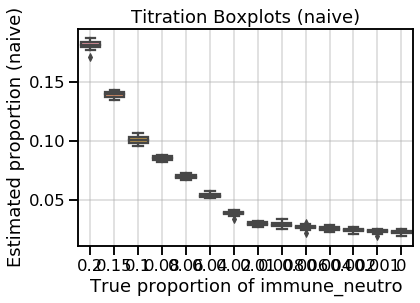

In [21]:
dcnv.boxplot_titration(list_of_deconvolution_dfs=deconvolution_naive,
                      cell_type=TITRATING_CELLTYPE_ATLAS,
                      true_proportions=TITRATION_LIST,
                      deconvolution_method_name='naive'
                      )

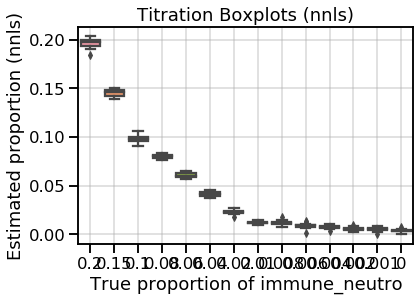

In [22]:
dcnv.boxplot_titration(list_of_deconvolution_dfs=deconvolution_nnls,
                      cell_type=TITRATING_CELLTYPE_ATLAS,
                      true_proportions=TITRATION_LIST,
                      deconvolution_method_name='nnls'
                      )

/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/scripts/deconvolution.py:242: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


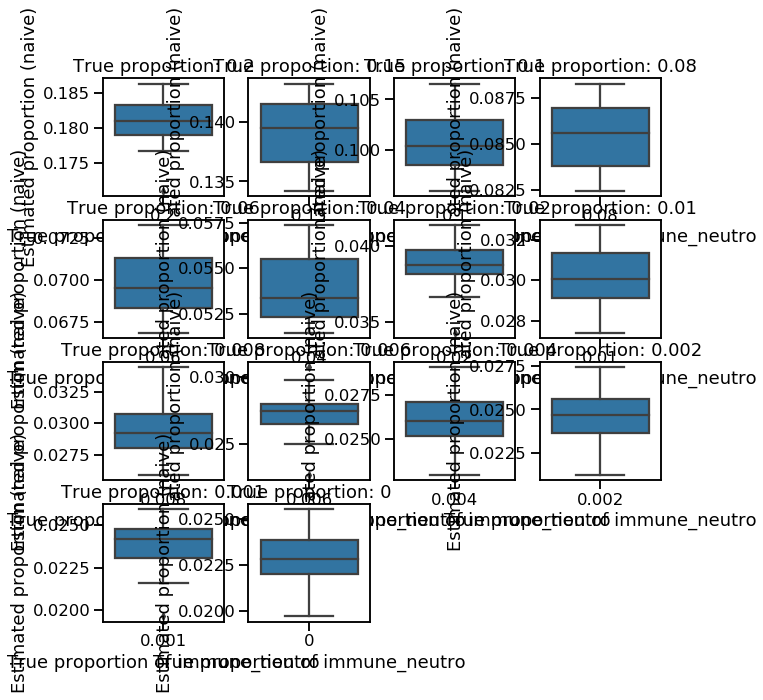

In [23]:

dcnv.boxplot_titration_zoom(list_of_deconvolution_dfs=deconvolution_naive,
                      cell_type=TITRATING_CELLTYPE_ATLAS,
                      true_proportions=TITRATION_LIST,
                      deconvolution_method_name='naive'
                      )

/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/scripts/deconvolution.py:242: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


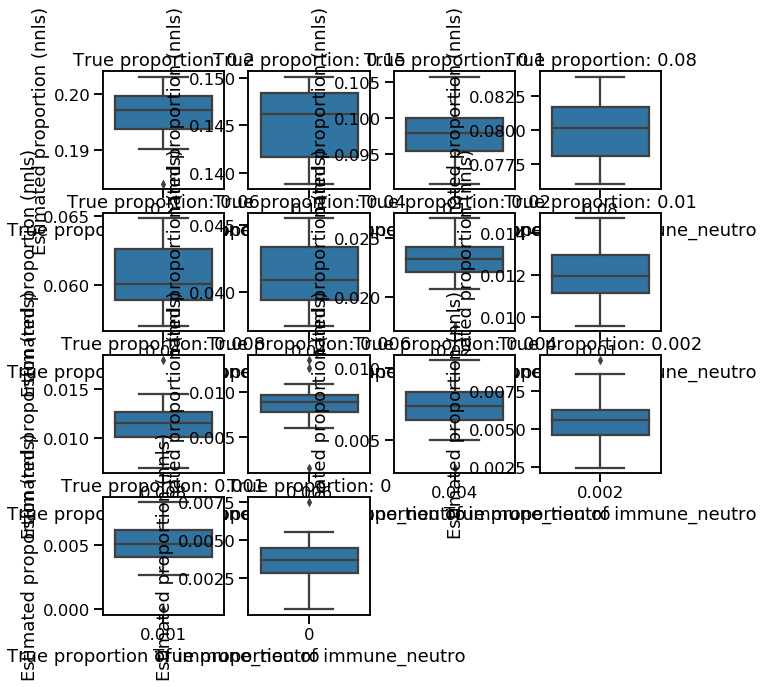

In [24]:

dcnv.boxplot_titration_zoom(list_of_deconvolution_dfs=deconvolution_nnls,
                      cell_type=TITRATING_CELLTYPE_ATLAS,
                      true_proportions=TITRATION_LIST,
                      deconvolution_method_name='nnls'
                      )